In [62]:
# from jax.config import config
# config.update('jax_enable_x64', True)

import jax.numpy as jnp
import jax

import numpy as np

from functools import partial

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from trajax import integrators

from trajax.experimental.sqp import util
from importlib import reload

reload(util)

<module 'trajax.experimental.sqp.util' from '/home/qdeng/.pyenv/versions/3.12.1/envs/AA203/lib/python3.12/site-packages/trajax/experimental/sqp/util.py'>

In [3]:
from trajax.optimizers import ilqr
from flax import struct
import chex

Array = jax.Array
Scalar = chex.Scalar

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.animation as animation

def animate_acrobot(x, t, filename='test_scp', params: AcrobotDynamicsParams=dynamics_params, dt=0.1):
    m1, m2, l1, lc1, lc2, I1, I2 = jax.flatten_util.ravel_pytree(params)[0]
    l2 = l1
    
    ## Convert Theta to Position
    pos_x_elbow = l1*jnp.sin(x[:,0]) 
    pos_y_elbow = -l1*jnp.cos(x[:,0]) 
    
    pos_x_end = pos_x_elbow+l2*jnp.sin(x[:,0]+x[:,1]) 
    pos_y_end = pos_y_elbow-l2*jnp.cos(x[:,0]+x[:,1]) 

    # Figure and axis
    fig, ax = plt.subplots(dpi=100)
    x_min, x_max, y_min, y_max = -1.1 * (l1+l2), 1.1 * (l1+l2), -1.1 * (l1+l2), 1.1 * (l1+l2)
    ax.plot(0.0, 0.0, "X", linewidth=0.1, color="k")#[0]
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    
    # Artists
    link1 = ax.plot([], [], "-", linewidth=3, color="b")[0]
    link2 = ax.plot([], [], "-", linewidth=3, color="g")[0]
    elbow = ax.plot([], [], "ro", linewidth=3)[0]
    trace = ax.plot([], [], "--", linewidth=2, color="tab:orange")[0]
    timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)
    
    def animate(k, t):
        # Geometry
        link1.set_data([0, pos_x_elbow[k]], [0, pos_y_elbow[k]])
        link2.set_data([pos_x_elbow[k], pos_x_end[k]], [pos_y_elbow[k], pos_y_end[k]])
        elbow.set_data([pos_x_elbow[k], pos_x_elbow[k]], [pos_y_elbow[k],pos_y_elbow[k]])
        trace.set_data(pos_x_end[:k], pos_y_end[:k])
    
        # Time-stamp
        timestamp.set_text("t = {:.1f} s".format(t[k]))
    
        artists = (link1, link2, elbow, trace, timestamp)
        return artists
    
    ani = animation.FuncAnimation(
        fig, animate, t.size, fargs=(t,), interval=dt * 1000, blit=True
    )

    # filename = 'test_scp_fine'

    ani.save(f"{filename}.mp4", writer="ffmpeg")
    fig.savefig(f'./{filename}.png') 
            

In [4]:
n = 4
m = 1

In [5]:
@struct.dataclass
class AcrobotDynamicsParams:
    
    LINK_MASS_1: float = 1.0
    LINK_MASS_2: float = 1.0
    LINK_LENGTH_1: float = 1.0
    LINK_COM_POS_1: float = 0.5
    LINK_COM_POS_2: float = 0.5
    LINK_MOI_1: float = 1.0
    LINK_MOI_2: float = 1.0


def acrobot(
    x: Array,
    u: Array,
    t: Scalar,
    params: AcrobotDynamicsParams
) -> Array:
    """Classic Acrobot system.

    Note this implementation emulates the OpenAI gym implementation of
    Acrobot-v2, which itself is based on Stutton's Reinforcement Learning book.

    https://gymnasium.farama.org/environments/classic_control/acrobot/

    Args:
      x: state, (4, ) array
      u: control, (1, ) array
      t: scalar time. Disregarded because system is time-invariant.
      params: tuple of (LINK_MASS_1, LINK_MASS_2, LINK_LENGTH_1, LINK_COM_POS_1,
        LINK_COM_POS_2 LINK_MOI_1, LINK_MOI_2)

    Returns:
      xdot: state time derivative, (4, )
    """
    del t  # Unused

    m1, m2, l1, lc1, lc2, I1, I2 = jax.flatten_util.ravel_pytree(params)[0]
    g = 9.8
    a = u[0] #+ 10*(np.random.rand()-0.5)#jax.random.uniform(jax.random.PRNGKey(0),minval=-5,maxval=5,shape=(1,1))[0]
    theta1 = x[0]
    theta2 = x[1]
    dtheta1 = x[2]
    dtheta2 = x[3]
    d1 = (
        m1 * lc1**2 + m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * jnp.cos(theta2)) + I1 +
        I2)
    d2 = m2 * (lc2**2 + l1 * lc2 * jnp.cos(theta2)) + I2
    phi2 = m2 * lc2 * g * jnp.cos(theta1 + theta2 - jnp.pi / 2.)
    phi1 = (-m2 * l1 * lc2 * dtheta2**2 * jnp.sin(theta2) -
            2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * jnp.sin(theta2) +
            (m1 * lc1 + m2 * l1) * g * jnp.cos(theta1 - jnp.pi / 2) + phi2)
    ddtheta2 = ((a + d2 / d1 * phi1 -
                 m2 * l1 * lc2 * dtheta1**2 * jnp.sin(theta2) - phi2) /
                (m2 * lc2**2 + I2 - d2**2 / d1))
    ddtheta1 = -(d2 * ddtheta2 + phi1) / d1
    return jnp.array([dtheta1, dtheta2, ddtheta1, ddtheta2])


In [88]:
dt = 0.1
T = 50
goal = jnp.array([jnp.pi, 0.0, 0.0, 0.0])


@struct.dataclass
class AcrobotCostParams:
    stage_cost_x: float = 0.1
    stage_cost_u: float = 0.01
    term_cost_x: float = 1000.0


def acrobot_cost(
    x: Array,
    u: Array,
    t: Scalar,
    params: AcrobotCostParams
) -> float:
    delta = x - goal
    terminal_cost = 0.5 * params.term_cost_x * jnp.dot(delta, delta)
    stage_cost = 0.5 * params.stage_cost_x * jnp.dot(
        delta, delta) + 0.5 * params.stage_cost_u * jnp.dot(u, u)
    return jnp.where(t == T, terminal_cost, stage_cost)


In [89]:
def acrobot_soln(
    dynamics_params: AcrobotDynamicsParams, 
    cost_params: AcrobotCostParams
) -> float:
    dynamics = integrators.euler(
        partial(acrobot, params=dynamics_params), dt=0.1)
    x0 = np.random.rand(4)
    U = jnp.zeros((T, 1))
    return ilqr(
        partial(acrobot_cost, params=cost_params),
        dynamics, x0, U,
        maxiter=100, make_psd=False, vjp_method='explicit')
    # return jnp.sum(U ** 2)


In [99]:
dynamics_params = AcrobotDynamicsParams()
cost_params = AcrobotCostParams()
soln = acrobot_soln(dynamics_params, cost_params)

In [107]:
soln[0].shape

(51, 4)

In [108]:
soln[1].shape

(50, 1)

In [104]:
x_sim = [soln[0][0,:]]

for u in soln[1]:
    x_next = dynamics(x_sim[-1], u, 0)
    x_sim.append(x_next)

x_sim = np.array(x_sim)

x_sim

array([[ 5.6127214e-01,  6.0297447e-01,  6.7897815e-01,  6.9810325e-01],
       [ 6.2916994e-01,  6.7278481e-01,  7.4384242e-01, -1.8781358e-01],
       [ 7.0355415e-01,  6.5400344e-01,  6.1056441e-01, -6.5968001e-01],
       [ 7.6461059e-01,  5.8803546e-01,  3.6535802e-01, -8.9548290e-01],
       [ 8.0114639e-01,  4.9848717e-01,  6.1009318e-02, -9.9960095e-01],
       [ 8.0724734e-01,  3.9852709e-01, -2.6823264e-01, -1.0382533e+00],
       [ 7.8042406e-01,  2.9470176e-01, -5.9927690e-01, -1.0523666e+00],
       [ 7.2049636e-01,  1.8946509e-01, -9.1606897e-01, -1.0633500e+00],
       [ 6.2888944e-01,  8.3130091e-02, -1.2070929e+00, -1.0767304e+00],
       [ 5.0818014e-01, -2.4542950e-02, -1.4639587e+00, -1.0848850e+00],
       [ 3.6178428e-01, -1.3303146e-01, -1.6805104e+00, -1.0700610e+00],
       [ 1.9373323e-01, -2.4003756e-01, -1.8515563e+00, -1.0097152e+00],
       [ 8.5776001e-03, -3.4100908e-01, -1.9706640e+00, -8.8545382e-01],
       [-1.8848881e-01, -4.2955446e-01, -2.0280287e

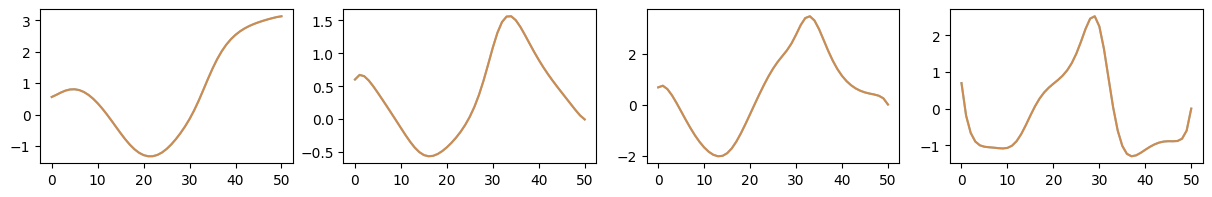

In [106]:
n = 4
fig, ax = plt.subplots(1, n, figsize=(15, 2))

for i in range(n):
    ax[i].plot(soln[0][:,i], alpha=2/3)
    ax[i].plot(x_sim[:,i], alpha=2/3)
    

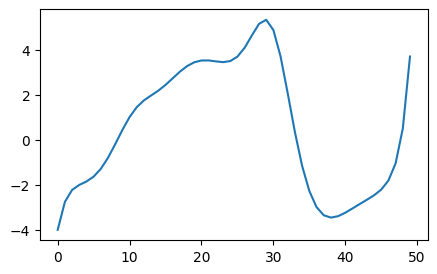

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(soln[1])

In [93]:
np.arange(0, T+1)*0.1

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

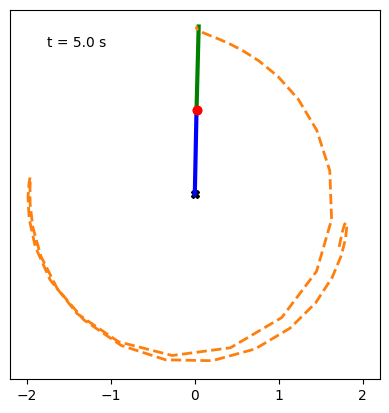

In [94]:
animate_acrobot(soln[0], np.arange(0, T+1)*0.1, filename='test_trajax_ilqr_rand')

### MPC with iLQR

In [95]:
N_mpc = 50  # MPC horizon
N_ilqr = 50  # maximum number of LQR iterations

T = 50  # total simulation time step
dt = 0.1
t = np.arange(0.0, (T + 1)*dt, dt)
x_mpc = np.zeros((T , N_mpc + 1, n))
u_mpc = np.zeros((T , N_mpc, m))

In [96]:
def acrobot_solve(
    dynamics_params: AcrobotDynamicsParams, 
    cost_params: AcrobotCostParams,
    x0,
    U,
    lqr_inter
) -> float:
    dynamics = integrators.euler(
        partial(acrobot, params=dynamics_params), dt=0.1)
    return ilqr(
        partial(acrobot_cost, params=cost_params),
        dynamics, x0, U,
        maxiter=lqr_inter, make_psd=False, vjp_method='explicit')
    # return jnp.sum(U ** 2)


In [97]:
x0 = jnp.zeros(4)
U = jnp.zeros((T, 1))
dynamics = integrators.euler(partial(acrobot, params=dynamics_params), dt=0.1)
for k in tqdm(range(T)):
    soln = acrobot_solve(dynamics_params, cost_params, x0, U, N_ilqr)
    x_mpc[k,:,:] = soln[0]
    u_mpc[k,:,:] = soln[1]

    # ax[i].plot(x_mpc[6,:,i]
    x0 = dynamics(x_mpc[k,0,:], u_mpc[k,0,:], 0)
    U = soln[1]
    # break

100%|███████████████████████████████████████████| 50/50 [01:51<00:00,  2.24s/it]


In [ ]:
apesh

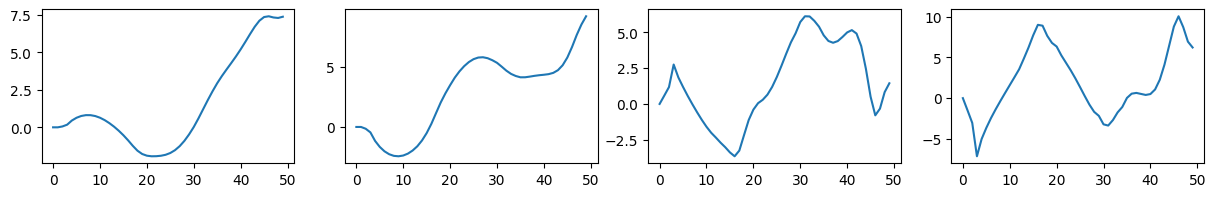

In [98]:
n = 4
fig, ax = plt.subplots(1, n, figsize=(15, 2))

for i in range(n):
    ax[i].plot(x_mpc[:,0,i])

0


IndexError: index 50 is out of bounds for axis 0 with size 50

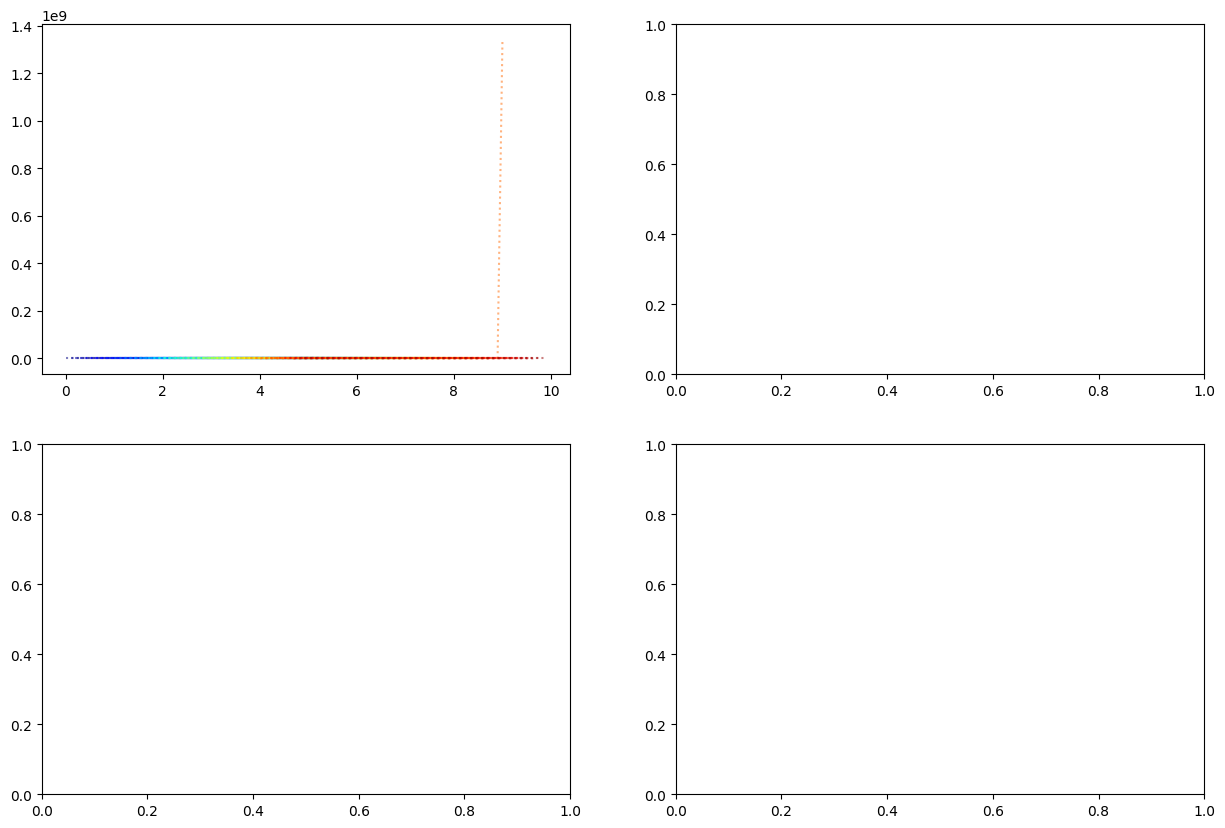

In [68]:
fig, ax = plt.subplots(n//2, n//2, figsize=(15, 10))


colors = plt.cm.jet(np.linspace(0,1,len(t)))

for i in range(n):

    print(i)

    for k, t_k in enumerate(t):
        t_series = np.linspace(t_k, t_k+(N_mpc)*dt, num=N_mpc+1)#np.arange(t_k, t_k+(N_mpc+1)*dt, dt)[:11]
        # print(t_series , len(t_series))
        ax[i//2,i%2].plot(t_series, x_mpc[k,:,i],':', color=colors[k],alpha=0.5)

    ax[i//2,i%2].plot(t,x_mpc[:,0,i],'k.-')

# for t in range(T):
#     ax[0].plot(s_mpc[t, :, 0], s_mpc[t, :, 1], "--*", color="k")

np.linspace(t_k, t_k+(N_mpc)*dt, num=N_mpc+1)

In [69]:
dynamics = integrators.euler(
        partial(acrobot, params=dynamics_params), dt=0.1)
dynamics(soln[0][0],soln[1][0], 0)

Array([  5.0972686, -15.458278 ,   1.613982 ,  -2.5074127], dtype=float32)

In [59]:
len(soln[1])

50